### Import Python packages


In [1]:
# ! uv pip install E:\Work\ruzt\msyrs --upgrade

In [2]:
import macrosynergy
import pandas as pd
import numpy as np
import polars as pl
import time
import os

from macrosynergy.panel import view_timelines
from macrosynergy.management.types import QuantamentalDataFrame

### Import Python bindings - `msyrs`


In [3]:
import msyrs

In [4]:
DATA_FOLDER_PATH = "E:/Work/jpmaqs-data"

In [5]:
cids_dm = "AUD.CAD.CHF.EUR.GBP.JPY.NOK.NZD.SEK.USD".split(".")
cids_em = "CLP.COP.CZK.HUF.IDR.ILS.INR.KRW.MXN.PLN.THB.TRY.TWD.ZAR".split(".")
cids = cids_dm + cids_em
cids_dux = list(set(cids) - set(["IDR", "NZD"]))
ecos = "CPIC_SA_P1M1ML12.CPIC_SJA_P3M3ML3AR.CPIC_SJA_P6M6ML6AR.CPIH_SA_P1M1ML12.CPIH_SJA_P3M3ML3AR.CPIH_SJA_P6M6ML6AR.INFTEFF_NSA.INTRGDP_NSA_P1M1ML12_3MMA.INTRGDPv5Y_NSA_P1M1ML12_3MMA.PCREDITGDP_SJA_D1M1ML12.RGDP_SA_P1Q1QL4_20QMA.RYLDIRS02Y_NSA.RYLDIRS05Y_NSA.PCREDITBN_SJA_P1M1ML12".split(
    "."
)


mkts = "DU02YXR_NSA.DU05YXR_NSA.DU02YXR_VT10.DU05YXR_VT10.EQXR_NSA.EQXR_VT10.FXXR_NSA.FXXR_VT10.FXCRR_NSA.FXTARGETED_NSA.FXUNTRADABLE_NSA".split(
    "."
)
xcats = ecos + mkts

cpi_xcats = "CPIC_SA_P1M1ML12.CPIC_SJA_P3M3ML3AR.CPIC_SJA_P6M6ML6AR.CPIH_SA_P1M1ML12.CPIH_SJA_P3M3ML3AR.CPIH_SJA_P6M6ML6AR".split(
    "."
)

tickers = [f"{c}_{x}" for c in cids for x in xcats]

In [6]:
starttime = time.time()

big_df: pl.DataFrame = msyrs.qdf.load_qdf_from_download_bank(
    folder_path=DATA_FOLDER_PATH,
    xcats=xcats,
)
print(f"Time taken to load qdf batch: {time.time() - starttime}")

Time taken to load qdf batch: 2.7522997856140137


In [7]:
big_df.estimated_size("mb")

286.69339656829834

In [8]:
sel_cids = ["USD", "EUR", "GBP", "AUD", "CAD"]
start = "1990-01-01"
nb_start_time = time.time()

### Running with uniform weights, 2 xcats, 5 cids


In [9]:
fx_xcats = [xc for xc in xcats if xc.startswith("FX")]
eq_xcats = [xc for xc in xcats if xc.startswith("EQ")]
starttime = time.time()

eq_df = msyrs.qdf.reduce_dataframe(
    df=big_df,
    cids=sel_cids,
    xcats=fx_xcats + eq_xcats + cpi_xcats,
    start=start,
)

fx_df = msyrs.qdf.reduce_dataframe(
    df=big_df, cids=sel_cids, start=start, xcats=fx_xcats, intersect=True
)
new_df: pl.DataFrame = msyrs.qdf.update_dataframe(df=eq_df, df_add=fx_df)

print(f"Time taken to reduce qdf: {time.time() - starttime}")

Time taken to reduce qdf: 1.0994884967803955


In [ ]:
_cids = ["USD", "CAD"]

_df = new_df.to_pandas()
starttime = time.time()


mx = macrosynergy.panel.linear_composite(
    df=_df,
    xcats=["EQXR_NSA", "FXXR_NSA"],
    cids=_cids,
    weights=None,
    signs=None,
    normalize_weights=False,
    start=None,
    end=None,
    blacklist=None,
    complete_xcats=False,
    complete_cids=False,
    new_xcat="COMPOSITE",
    new_cid="GLB",
)
print(f"Time taken to run linear composite: {time.time() - starttime}")


# view_timelines(QuantamentalDataFrame(mx), cids=_cids)

Time taken to run linear composite: 0.19902491569519043


e:\Work\ruzt\msyrs\.venv\Lib\site-packages\macrosynergy\panel\linear_composite.py:437: UserWarning: USD does not have complete xcat data for ['FXXR_NSA']. These will be filled with NaNs for the calculation.
  warnings.warn(wrn_msg.format(cidx=cidx, missing_xcats=missing_xcats))


In [ ]:
_cids = ["USD", "CAD"]
starttime = time.time()

x = msyrs.panel.linear_composite(
    df=new_df,
    xcats=["EQXR_NSA", "FXXR_NSA"],
    cids=_cids,
    weights=None,
    signs=None,
    weight_xcats=None,
    normalize_weights=False,
    start=None,
    end=None,
    blacklist=None,
    complete_xcats=False,
    complete_cids=False,
    new_xcat="COMPOSITE",
    new_cid="GLB",
)
print(f"Time taken to run linear composite rs: {time.time() - starttime}")

# view_timelines(QuantamentalDataFrame(x.to_pandas()), cids=_cids)

Time taken to run linear composite rs: 0.047815799713134766


### Running with variable weights


e:\Work\ruzt\msyrs\.venv\Lib\site-packages\macrosynergy\panel\linear_composite.py:437: UserWarning: USD does not have complete xcat data for ['FXXR_NSA']. These will be filled with NaNs for the calculation.
  warnings.warn(wrn_msg.format(cidx=cidx, missing_xcats=missing_xcats))


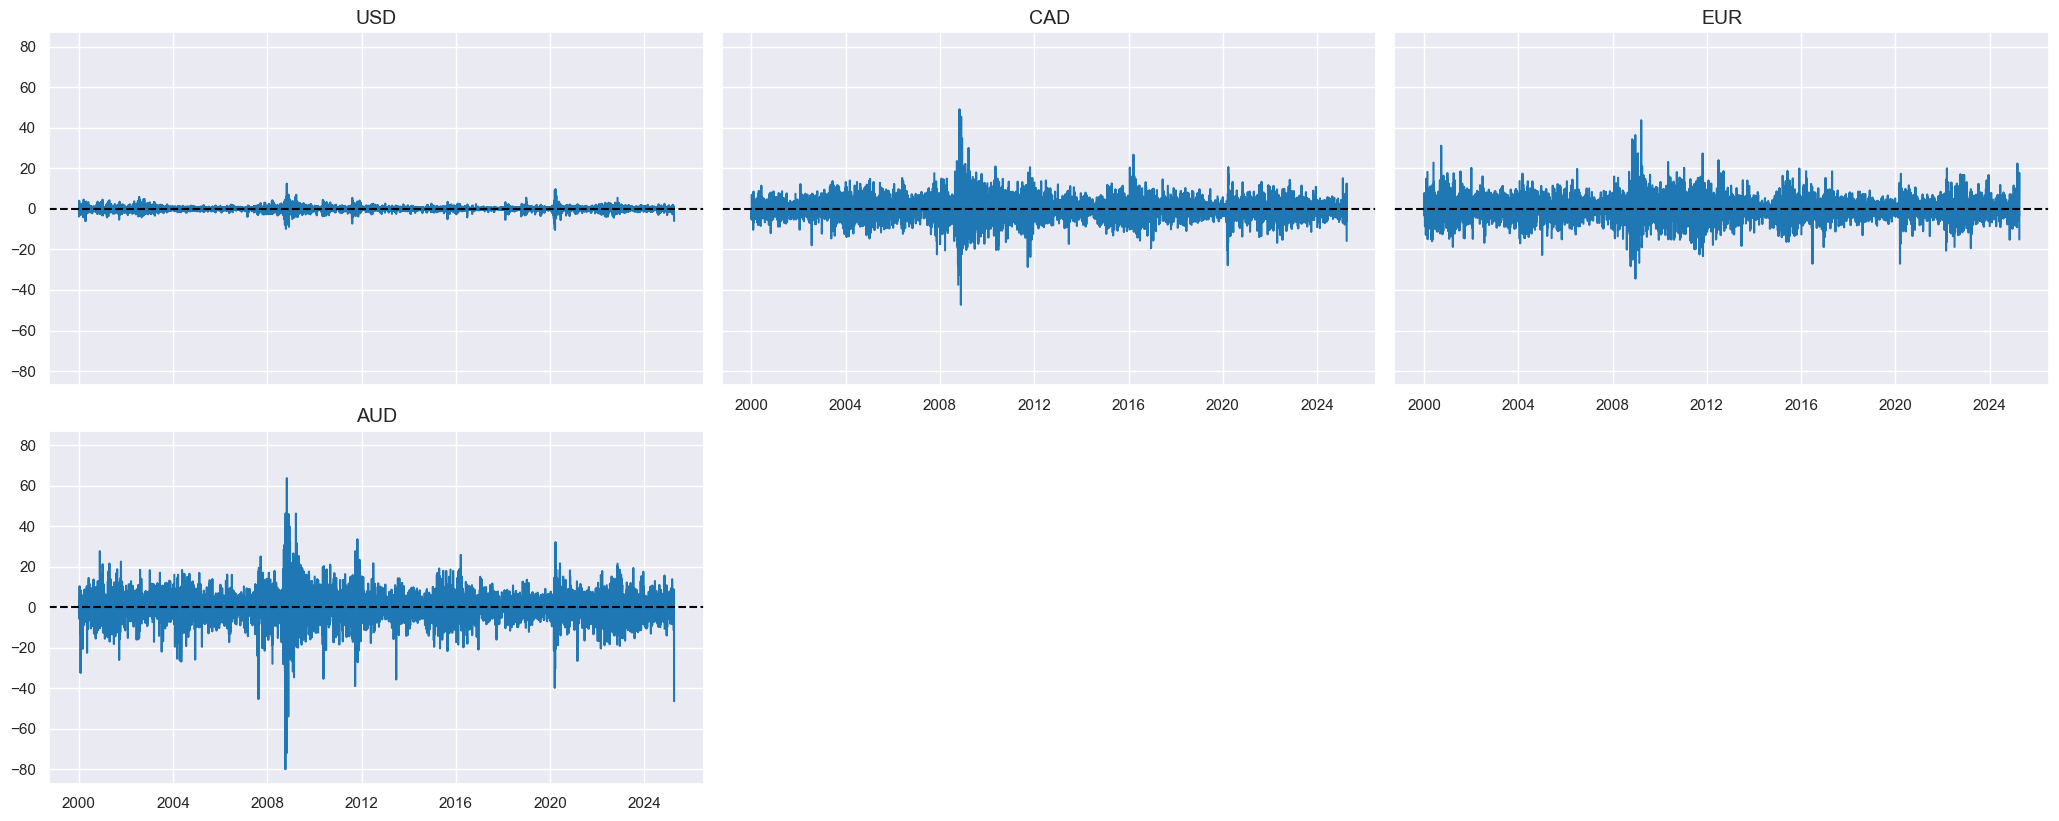

True

In [12]:
_cids = ["USD", "CAD", "EUR", "AUD"]
_xcats = ["EQXR_NSA", "FXXR_NSA"]

mx = macrosynergy.panel.linear_composite(
    df=new_df.to_pandas(),
    xcats=_xcats,
    cids=_cids,
    weights=[1, 9],
    normalize_weights=False,
    new_xcat="COMPOSITE",
    new_cid="GLB",
)
x = msyrs.panel.linear_composite(
    df=new_df,
    xcats=_xcats,
    cids=_cids,
    weights=[1, 9],
    normalize_weights=False,
    new_xcat="COMPOSITE",
    new_cid="GLB",
)
view_timelines(QuantamentalDataFrame(mx), cids=_cids)
mwide = QuantamentalDataFrame(mx).to_wide().sort_index()
rwide = QuantamentalDataFrame(x.to_pandas()).to_wide().sort_index()
np.allclose((mwide - rwide).sum(axis=1), 0)

### Running with variable weights, normalized


In [13]:
x = msyrs.panel.linear_composite(
    df=new_df,
    xcats=cpi_xcats,
    cids=_cids,
    weights=list(range(1, len(cpi_xcats) + 1)),
    normalize_weights=True,
    new_xcat="COMPOSITE",
    new_cid="GLB",
)
x.to_pandas().dropna(how="any")

real_date     value  cid       xcat
22    1990-02-20  3.592367  CAD  COMPOSITE
23    1990-02-21  3.592367  CAD  COMPOSITE
24    1990-02-22  3.592367  CAD  COMPOSITE
25    1990-02-23  3.592367  CAD  COMPOSITE
26    1990-02-26  3.592367  CAD  COMPOSITE
...          ...       ...  ...        ...
35319 2025-03-31  2.721470  AUD  COMPOSITE
35320 2025-04-01  2.721470  AUD  COMPOSITE
35321 2025-04-02  2.721470  AUD  COMPOSITE
35322 2025-04-03  2.721470  AUD  COMPOSITE
35323 2025-04-04  2.721470  AUD  COMPOSITE

[33163 rows x 4 columns]

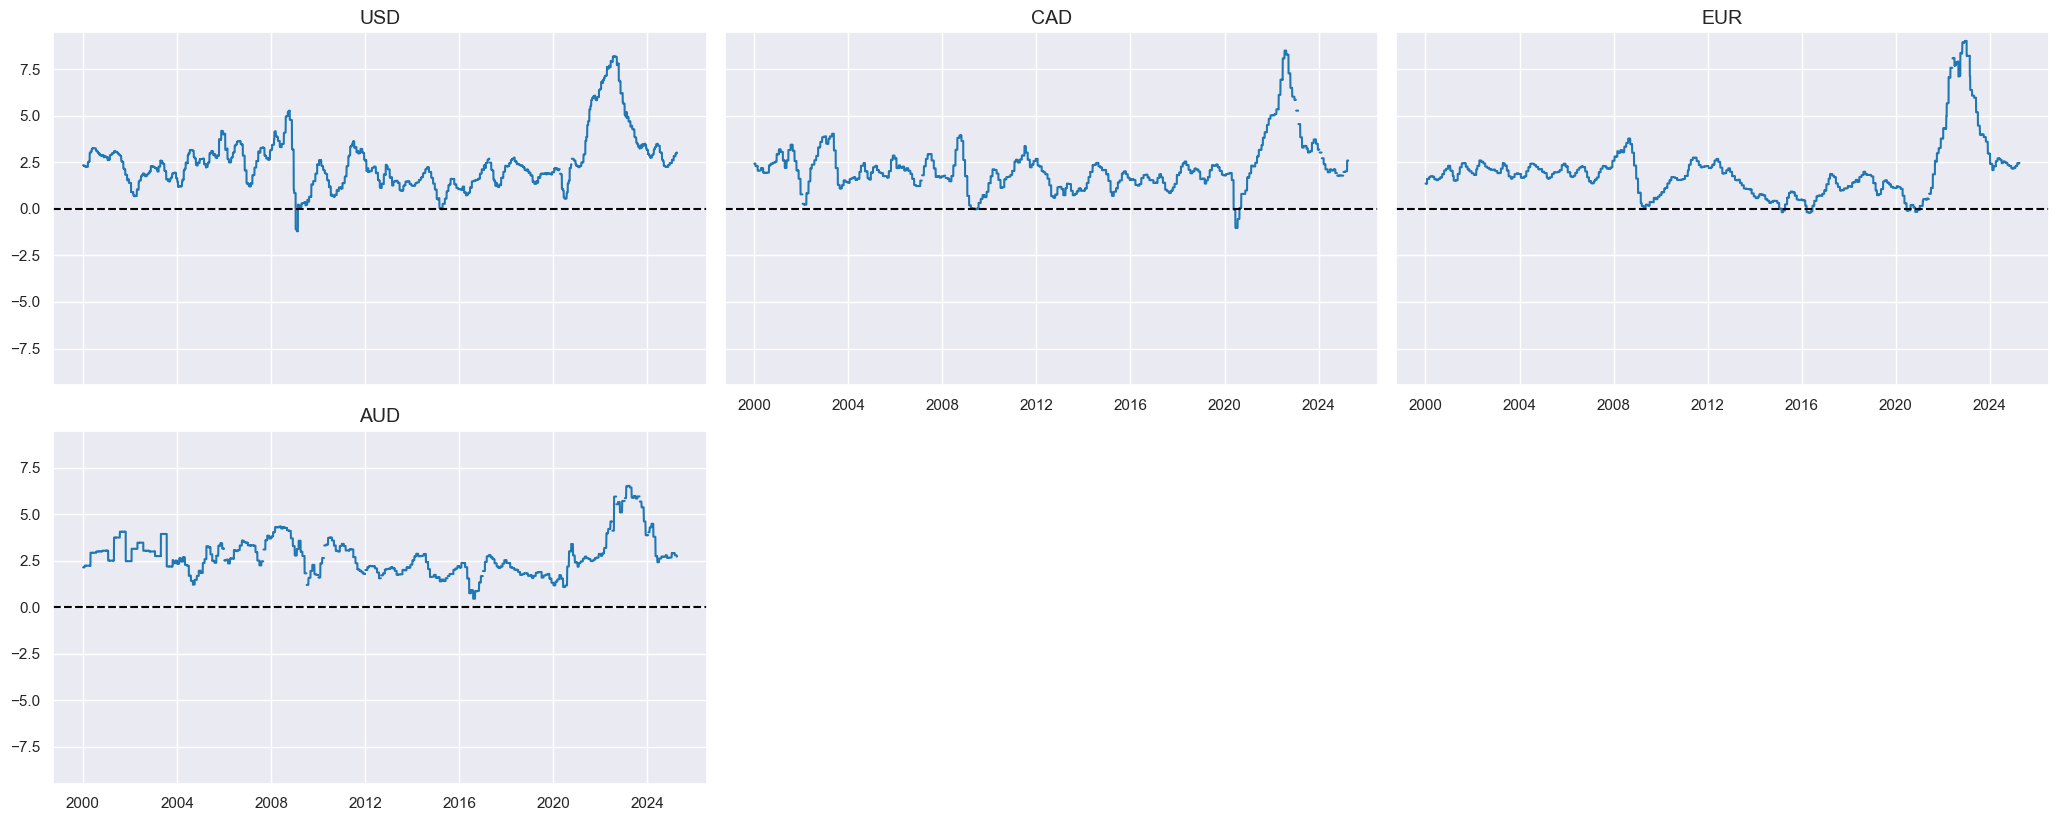

In [14]:
view_timelines(x.to_pandas().dropna(how="any"), cids=_cids)

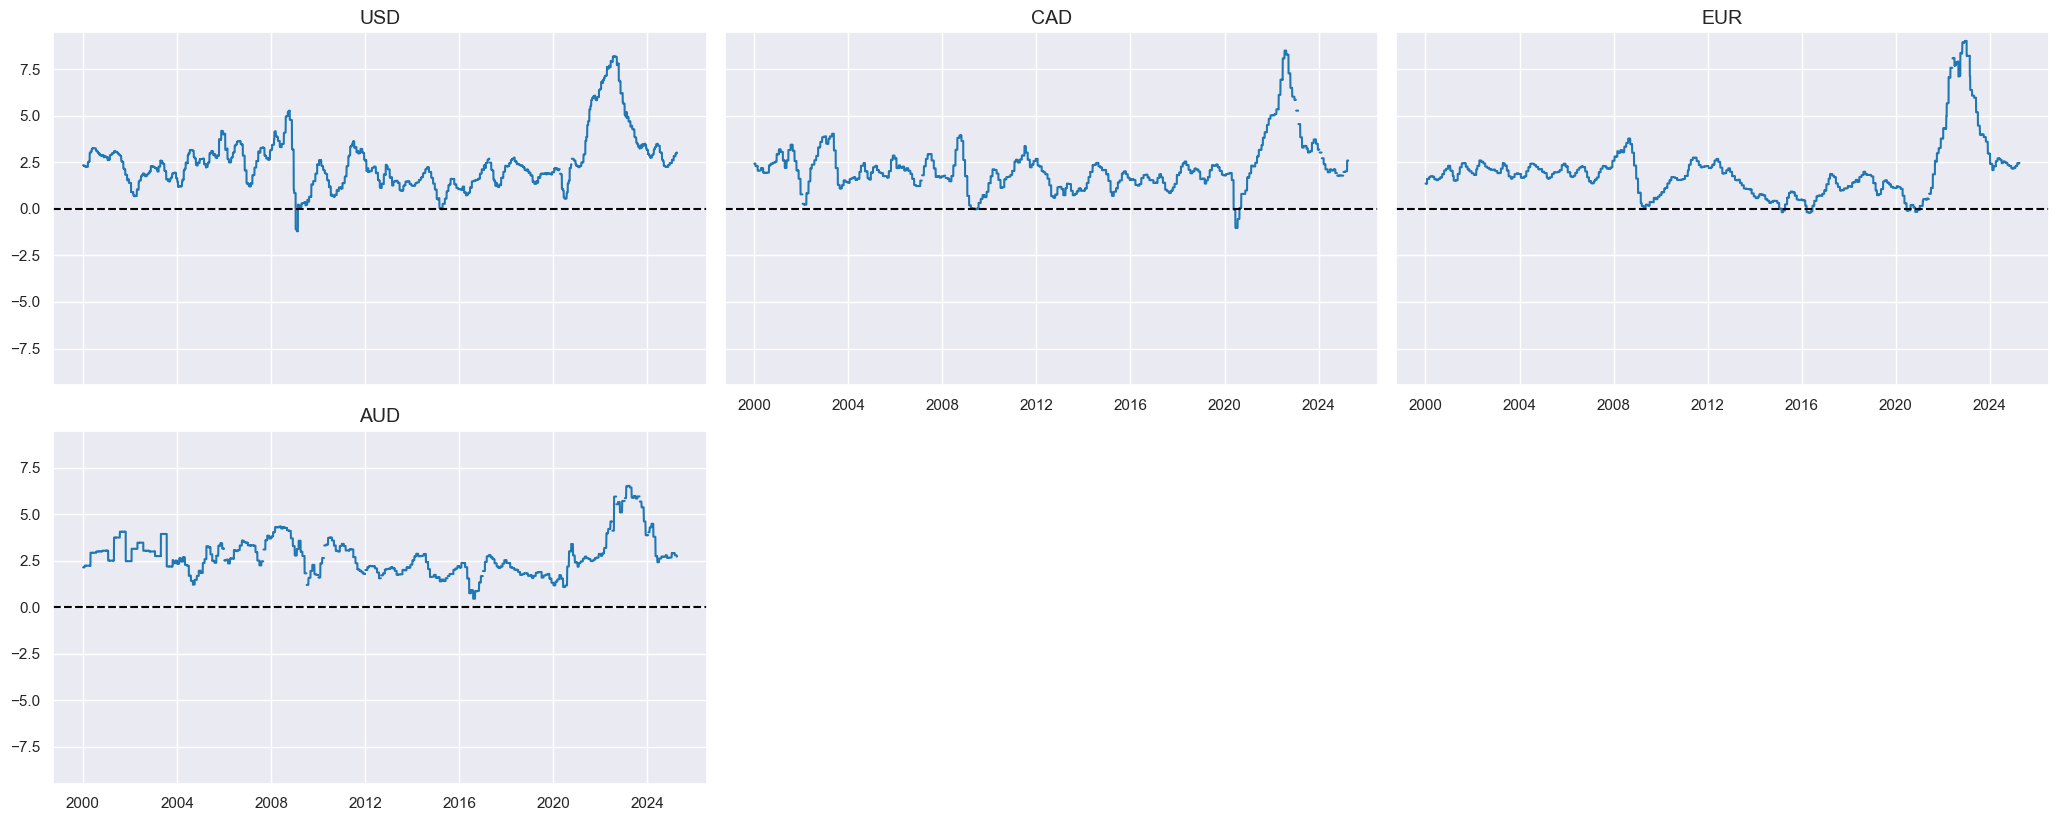

In [15]:
mx = macrosynergy.panel.linear_composite(
    df=new_df.to_pandas(),
    xcats=cpi_xcats,
    cids=_cids,
    weights=list(range(1, len(cpi_xcats) + 1)),
    normalize_weights=True,
    new_xcat="COMPOSITE",
    new_cid="GLB",
)
view_timelines(mx.dropna(how="any"), cids=_cids)

In [16]:
mwide = QuantamentalDataFrame(mx).to_wide().sort_index()
rwide = QuantamentalDataFrame(x.to_pandas()).to_wide().sort_index()
np.allclose((mwide - rwide).sum(axis=1), 0)

True

### Running with categorical weights, normalized


In [17]:
raise NotImplementedError("Not implemented yet")

NotImplementedError: Not implemented yet